In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns 
import tensorflow as tf
# import keras 
# from keras.models import Sequential
# from keras.layers import Conv2D,MaxPool2D, UpSampling2D,Dropout

import numpy as np
import torch.nn as nn
import torch
import torch.optim as optim
import argparse

In [2]:
from Utils_inverse_prob import *
from network import *
from algorithm_inv_prob import *

In [3]:
def def_args(grayscale=False, num_kernels = 28):
    '''
    @ grayscale: if True, number of input and output channels are set to 1. Otherwise 3
    @ training_data: models provided in here have been trained on {BSD400, mnist, BSD300}
    @ training_noise: standard deviation of noise during training the denoiser
    '''
    parser = argparse.ArgumentParser(description='BF_CNN_color')
    parser.add_argument('--dir_name', default= '../noise_range_')
    parser.add_argument('--kernel_size', default= 3)
    parser.add_argument('--padding', default= 1)
    parser.add_argument('--num_kernels', default= num_kernels)
    parser.add_argument('--num_layers', default= 20)
    if grayscale is True: 
        parser.add_argument('--num_channels', default= 1)
    else:
        parser.add_argument('--num_channels', default= 3)
    
    args = parser.parse_args('')
    return args

In [4]:
class BF_CNN(nn.Module):

    def __init__(self, args):
        super(BF_CNN, self).__init__()

        self.padding = args.padding
        self.num_kernels = args.num_kernels
        self.kernel_size = args.kernel_size
        self.num_layers = args.num_layers
        self.num_channels = args.num_channels

        self.conv_layers = nn.ModuleList([])
        self.running_sd = nn.ParameterList([])
        self.gammas = nn.ParameterList([])

        # self.conv_layers.append(PrintShape())
        self.conv_layers.append(nn.Conv2d(self.num_channels,self.num_kernels, self.kernel_size, padding=self.padding , bias=False))

        for l in range(1,self.num_layers-1):
            # self.conv_layers.append(PrintShape())
            self.conv_layers.append(nn.Conv2d(self.num_kernels ,self.num_kernels, self.kernel_size, padding=self.padding , bias=False))
            self.running_sd.append( nn.Parameter(torch.ones(1,self.num_kernels,1,1), requires_grad=False) )
            g = (torch.randn( (1,self.num_kernels,1,1) )*(2./9./64.)).clamp_(-0.025,0.025)
            self.gammas.append(nn.Parameter(g, requires_grad=True) )

        self.conv_layers.append(nn.Conv2d(self.num_kernels,self.num_channels, self.kernel_size, padding=self.padding , bias=False))
        


    def forward(self, x):
        relu = nn.ReLU(inplace=True)
        x = relu(self.conv_layers[0](x))
        for l in range(1,self.num_layers-1):
            x = self.conv_layers[l](x)
            # BF_BatchNorm
            sd_x = torch.sqrt(x.var(dim=(0,2,3) ,keepdim = True, unbiased=False)+ 1e-05)

            if self.conv_layers[l].training:
                x = x / sd_x.expand_as(x)
                self.running_sd[l-1].data = (1-.1) * self.running_sd[l-1].data + .1 * sd_x
                x = x * self.gammas[l-1].expand_as(x)

            else:
                x = x / self.running_sd[l-1].expand_as(x)
                x = x * self.gammas[l-1].expand_as(x)

            x = relu(x)

        x = self.conv_layers[-1](x)

        return x



In [5]:
args = def_args(grayscale=True,num_kernels=64)
# Initialize the model, loss function, and optimizer
model = BF_CNN(args)
model.load_state_dict(torch.load('bf_cnn_mnist_proper_training3.pth',map_location=torch.device('cpu')))
model.eval()

BF_CNN(
  (conv_layers): ModuleList(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1-18): 18 x Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (19): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (running_sd): ParameterList(
      (0): Parameter containing: [torch.float32 of size 1x64x1x1]
      (1): Parameter containing: [torch.float32 of size 1x64x1x1]
      (2): Parameter containing: [torch.float32 of size 1x64x1x1]
      (3): Parameter containing: [torch.float32 of size 1x64x1x1]
      (4): Parameter containing: [torch.float32 of size 1x64x1x1]
      (5): Parameter containing: [torch.float32 of size 1x64x1x1]
      (6): Parameter containing: [torch.float32 of size 1x64x1x1]
      (7): Parameter containing: [torch.float32 of size 1x64x1x1]
      (8): Parameter containing: [torch.float32 of size 1x64x1x1]
      (9): Parameter containing: [torch.float32 of size 1x64x1x1]


In [6]:
%matplotlib inline

In [7]:
C = 1

In [8]:
from keras.datasets import mnist
(x_train,y_train),(x_test,y_test) = mnist.load_data()
# to get the shape of the data 
print("x_train shape:",x_train.shape)
print("x_test shape", x_test.shape)


val_images = x_test[:9000]
test_images = x_test[9000:]


val_images = val_images.astype('float32') / 255.0
val_images = np.reshape(val_images,(val_images.shape[0],1,28,28))

test_images = test_images.astype('float32') / 255.0
test_images = np.reshape(test_images,(test_images.shape[0],1,28,28))

train_images = x_train.astype("float32") / 255.0
train_images = np.reshape(train_images, (train_images.shape[0],1,28,28))


factor = 0.39
train_noisy_images = train_images + factor * np.random.normal(loc = 0.0,scale = 1.0,size = train_images.shape)
val_noisy_images = val_images + factor * np.random.normal(loc = 0.0,scale = 1.0,size = val_images.shape)
test_noisy_images = test_images + factor * np.random.normal(loc = 0.0,scale = 1.0,size = test_images.shape)

# here maximum pixel value for our images may exceed 1 so we have to clip the images
train_noisy_images = np.clip(train_noisy_images,0.,1.)
val_noisy_images = np.clip(val_noisy_images,0.,1.)
test_noisy_images = np.clip(test_noisy_images,0.,1.)



x_train shape: (60000, 28, 28)
x_test shape (10000, 28, 28)


In [9]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from PIL import Image
import random

class RandomCropMNISTDataset(Dataset):
    def __init__(self, root, transform=None, crop_size=24, num_crops=1, max_std=0.1, train=True):
        self.mnist_dataset = datasets.MNIST(root=root, train=train, transform=None, download=True)
        self.transform = transform
        self.crop_size = crop_size
        self.num_crops = num_crops
        self.max_std = max_std

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, index):
        image, label = self.mnist_dataset[index]

        # Perform random crops
        crops = []
        for _ in range(self.num_crops):
            x = random.randint(0, image.size[0] - self.crop_size)
            y = random.randint(0, image.size[1] - self.crop_size)
            cropped_image = image.crop((x, y, x + self.crop_size, y + self.crop_size))

            # Apply transformations
            if self.transform is not None:
                cropped_image = self.transform(cropped_image)

            # Add Gaussian noise to the cropped image
            std_dev = random.uniform(0, self.max_std)
            noised_image = self.add_gaussian_noise(cropped_image, std_dev)

            crops.append((cropped_image, noised_image, label))

        return crops

    def add_gaussian_noise(self, image, std_dev):
        noise = torch.randn_like(image) * std_dev
        noised_image = image + noise
        return noised_image

# Example usage:
# Define the transform to normalize and convert to PyTorch tensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

root = 'C:/Users/ANT/Documents/info/IIN_universal_inverse_problem/test_images/grayscale/mnist'
# Create the dataset
mnist_dataset = RandomCropMNISTDataset(root=root, transform=transform, crop_size=24, num_crops=5, max_std=0.1, train=True)

# Access a sample from the dataset
sample = mnist_dataset[0]


In [10]:
Xtrain = torch.FloatTensor(train_images)
Xtest = torch.FloatTensor(test_images)
Xval = torch.FloatTensor(val_images)

Xtrain_noisy = torch.FloatTensor(train_noisy_images)
Xtest_noisy = torch.FloatTensor(test_noisy_images)
Xval_noisy = torch.FloatTensor(val_noisy_images)

N = Xtrain.shape[0]

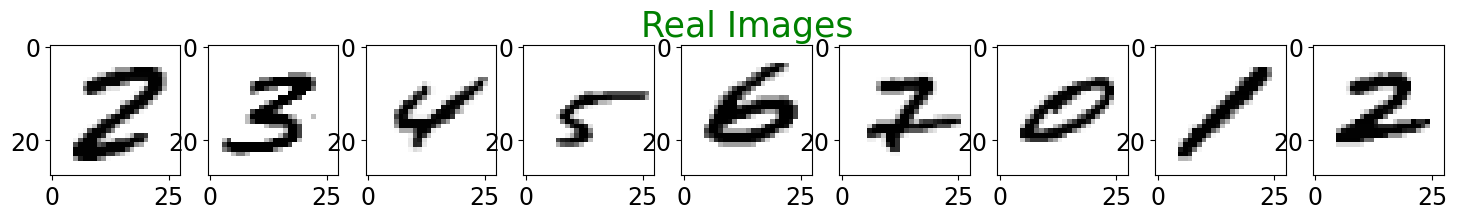

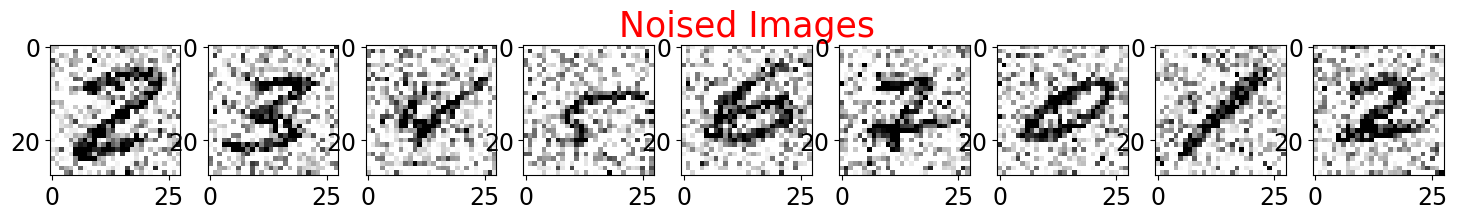

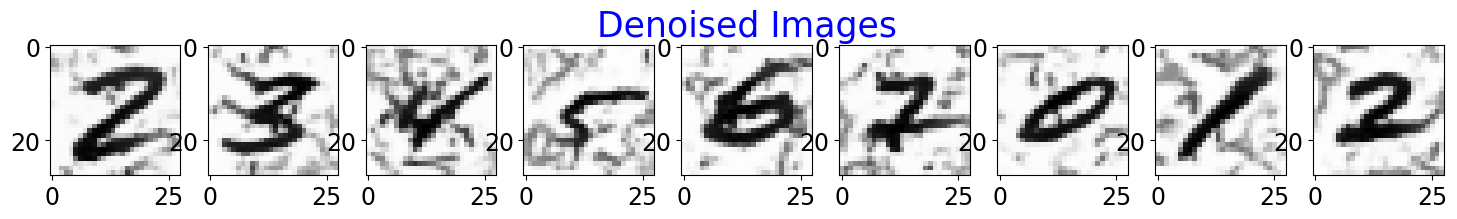

In [120]:
plt.figure(figsize = (18,18))
for i in range(10,19):
    plt.subplot(9,9,i)
    if(i == 14):
        plt.title('Real Images', fontsize = 25, color = 'Green') 
    plt.imshow(Xtest[i].reshape(1,28,28)[0], cmap = plt.cm.binary)
plt.show()


plt.figure(figsize = (18,18))
for i in range(10,19):
    if(i == 15):
        plt.title('Noised Images', fontsize = 25, color = 'red') 
    plt.subplot(9,9,i)
    plt.imshow(test_noisy_images[i].reshape(1,28,28)[0], cmap = plt.cm.binary)
plt.show()


plt.figure(figsize = (18,18))
for i in range(10,19):  
    if(i == 15):
        plt.title('Denoised Images', fontsize = 25, color = 'Blue') 
    
    plt.subplot(9,9,i)
    plt.imshow(model(Xtest_noisy[i].reshape(1,1,28,28)).detach().numpy().reshape(28,28), cmap = plt.cm.binary) 
plt.show()

In [118]:
args = def_args(grayscale=True,num_kernels=64)
# Initialize the model, loss function, and optimizer
model = BF_CNN(args)
model.load_state_dict(torch.load('bf_cnn_mnist_trained_with_crops_5.pth',map_location=torch.device('cpu')))
model.eval()

BF_CNN(
  (conv_layers): ModuleList(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1-18): 18 x Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (19): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (running_sd): ParameterList(
      (0): Parameter containing: [torch.float32 of size 1x64x1x1]
      (1): Parameter containing: [torch.float32 of size 1x64x1x1]
      (2): Parameter containing: [torch.float32 of size 1x64x1x1]
      (3): Parameter containing: [torch.float32 of size 1x64x1x1]
      (4): Parameter containing: [torch.float32 of size 1x64x1x1]
      (5): Parameter containing: [torch.float32 of size 1x64x1x1]
      (6): Parameter containing: [torch.float32 of size 1x64x1x1]
      (7): Parameter containing: [torch.float32 of size 1x64x1x1]
      (8): Parameter containing: [torch.float32 of size 1x64x1x1]
      (9): Parameter containing: [torch.float32 of size 1x64x1x1]


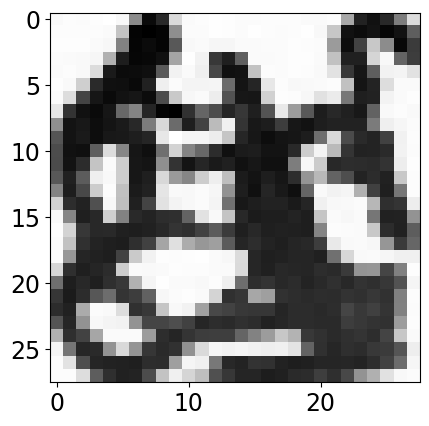

In [125]:
y = torch.randn((1,1,28,28)) + .5
for i in range(20):
    y += 0.2*(model(y) - y)   +  (0.01 *torch.randn_like(y) )
    plt.imshow(y.transpose(-3,-2).transpose(-2,-1).squeeze().detach().numpy(),cmap='Greys')
plt.show()

In [38]:
img = Xtest[0,...]
x_c = torch.zeros_like(img)

synth = synthesis() 
sample, interm_Ys = univ_inv_sol(model, 
                                 x_c = x_c, 
                                 task = synth,
                                 sig_0 = 1,
                                 sig_L = 0.001, 
                                 h0 = 0.2, 
                                 beta = 1,  # change beta to see how quality of generated samples change       
                                 freq = 20)

## plot the progression and the final sample
plot_synthesis(interm_Ys, sample)

----------------------------- 20
sigma  0.003791273105889559
----------------------------- 40
sigma  0.0032669908832758665
----------------------------- 60
sigma  0.0032454668544232845
----------------------------- 80
sigma  0.0028576659969985485


KeyboardInterrupt: 

value range -2.33 3.48


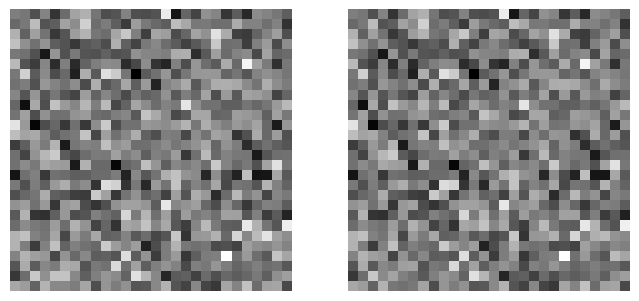

In [ ]:
plot_synthesis(interm_Ys[:5], sample[:5])

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from PIL import Image
import random

class RandomCropMNISTDataset(Dataset):
    def __init__(self, root, transform=None, crop_size=10, num_crops=1, max_std=0.1, train=True):
        self.mnist_dataset = datasets.MNIST(root=root, train=train, transform=None, download=True)
        self.transform = transform
        self.crop_size = crop_size
        self.num_crops = num_crops
        self.max_std = max_std

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, index):
        image, label = self.mnist_dataset[index]

        # Perform random crops
        crops = []
        for _ in range(self.num_crops):
            x = random.randint(0, image.size[0] - self.crop_size)
            y = random.randint(0, image.size[1] - self.crop_size)
            cropped_image = image.crop((x, y, x + self.crop_size, y + self.crop_size))

            # Apply transformations
            if self.transform is not None:
                cropped_image = self.transform(cropped_image)

            # Add Gaussian noise to the cropped image
            std_dev = random.uniform(0, self.max_std)
            noised_image = self.add_gaussian_noise(cropped_image, std_dev)

            crops.append((cropped_image, noised_image, label))

        return crops

    def add_gaussian_noise(self, image, std_dev):
        noise = torch.randn_like(image) * std_dev
        noised_image = image + noise
        return noised_image

# Example usage:
# Define the transform to normalize and convert to PyTorch tensor
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5,), (0.5,))
])

# Create the dataset
mnist_dataset = RandomCropMNISTDataset(root='./data', transform=transform, crop_size=24, num_crops=5, max_std=0.4, train=True)

# Access a sample from the dataset
sample = mnist_dataset[0]


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from PIL import Image
import random
from tqdm import tqdm

In [ ]:
test.shape

torch.Size([1, 24, 24])

tensor(0.) - tensor(1.)


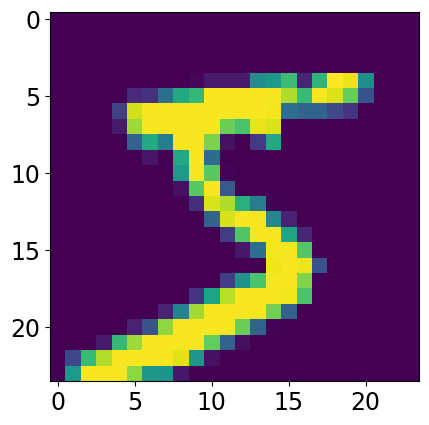

In [ ]:
test = mnist_dataset[0][0][0]
plt.imshow(test.squeeze())
print(test.min(),'-',test.max())

In [ ]:
stop

NameError: name 'stop' is not defined

In [ ]:
# Define the Mean Squared Error (MSE) loss
criterion = nn.MSELoss()

# Instantiate the model, optimizer, and dataset
model = BF_CNN(args)
optimizer = optim.Adam(model.parameters(), lr=0.001)
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5,), (0.5,))
])
mnist_dataset = RandomCropMNISTDataset(root='./data', transform=transform, crop_size=24, num_crops=1, max_std=0.1, train=True)

# DataLoader for batching and shuffling
dataloader = DataLoader(mnist_dataset, batch_size=64, shuffle=True)

# Training loop
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    running_loss = 0.0
    for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        batch_clean, batch_noised, _ = batch[0]
        batch_clean, batch_noised = batch_clean.to(device), batch_noised.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_noised)

        # Compute the MSE loss
        loss = criterion(outputs, batch_clean)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    average_loss = running_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}")

print("Training complete.")

Epoch 1/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1/10:   1%|▏         | 14/938 [00:15<17:02,  1.11s/it]


KeyboardInterrupt: 